# *"Predicción de la edad de los abalones en Hobart, Tasmania"*

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import Lasso

El conjunto de datos de abalones proviene de un estudio realizado en Tasmania, Australia, y busca predecir la edad de estos moluscos a partir de mediciones físicas. Tradicionalmente, determinar la edad en abalones requiere un proceso invasivo: cortar la concha, teñirla y contar los anillos bajo un microscopio, lo cual implica sacrificar al animal.

Este trabajo tiene como objetivo desarrollar un modelo de regresión que permita estimar la edad del abalon sin necesidad de sacrificarlo. Para ello, se analizarán y compararán dos enfoques: *la regresión lineal simple* y la *regresión lineal con Lasso*, explorando el ajuste de cada uno de estos modelos tanto con las características que incluyen el sacrificio del animal como con aquellas que no lo requieren. Algunas de las mediciones incluidas en el dataset son la longitud, el diámetro, la altura y varios pesos, utilizadas para predecir el número de anillos,la cual aproximadamente es la edad del abalon.

Los datos originales fueron recopilados por Warwick J. Nash y colaboradores en un estudio sobre la biología poblacional de los abalones. 

A través de esta comparación de modelos, el estudio evaluará la viabilidad de estimar la edad del abalon utilizando solo las características que no requieren el sacrificio del animal. Si el rendimiento de la *regresión Lasso* es aceptable únicamente con estas características, se contribuiría a la preservación de la especie y a un método de estimación menos invasivo.

Los datos fueron extraidos de: https://archive.ics.uci.edu/dataset/1/abalone y se pueden encontrar en el repositorio de github: https://github.com/bautistaturri/EntregaIAA/

## Análisis y preprocesamiento de los datos

In [253]:
df = pd.read_csv("./abalone.csv")
df.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


El dataset estaba originalmente preprocesado para trabajar con redes neuronales, por lo que fue necesario transformar los valores a su escala original. Esto se logra multiplicando cada elemento continuo del conjunto por 200, según lo indicado en la documentación.

In [254]:
columns_to_rescale = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']

df[columns_to_rescale] = df[columns_to_rescale] * 200
df.head(5)


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,91.0,73.0,19.0,102.8,44.9,20.2,30.0,15
1,M,70.0,53.0,18.0,45.1,19.9,9.7,14.0,7
2,F,106.0,84.0,27.0,135.4,51.3,28.3,42.0,9
3,M,88.0,73.0,25.0,103.2,43.1,22.8,31.0,10
4,I,66.0,51.0,16.0,41.0,17.9,7.9,11.0,7


In [255]:
df.shape

(4177, 9)

### Descripción de los atributos:

El dataset contiene 4177 instancias y 9 columnas. Donde, 7 son columnas con valores continuos y 2 con valores categoricos. Ademas de no contener valores faltantes.

- **Sex**: Variable categorica con tres posibles valores: M (macho), F (hembra) e I (infante). Esta variable indica el sexo del abalon.
- **Length**: Variable continua que mide la longitud del caparazón del abalon en milímetros.
- **Diameter**: Variable continua que mide el diámetro, perpendicular a la longitud, también en milímetros.
- **Height**: Variable continua que mide la altura del caparazón del abalon con la carne aún dentro, en milímetros.
- **Whole weight**: Variable continua que mide el peso total del abalon en gramos.
- **Shucked weight**: Variable continua que mide el peso de la carne del abalon en gramos, una vez que se ha quitado la concha.
- **Viscera weight**: Variable continua que mide el peso del intestino después de haber sido drenado de sangre, en gramos.
- **Shell weight**: Variable continua que mide el peso de la concha seca después de haber sido removida del abalone, en gramos.
- **Rings**: Variable continua, que indica el número de anillos en el caparazón del abalon. Se suma 1.5 a los anillos para obtener la edad aproximada del abalon en años.

Luego de ajustar los valores a la escala correcta, realizamos un *scatterplot* del *target* en función de cada *feature* continuo para identificar posibles tendencias o valores atípicos en los datos.

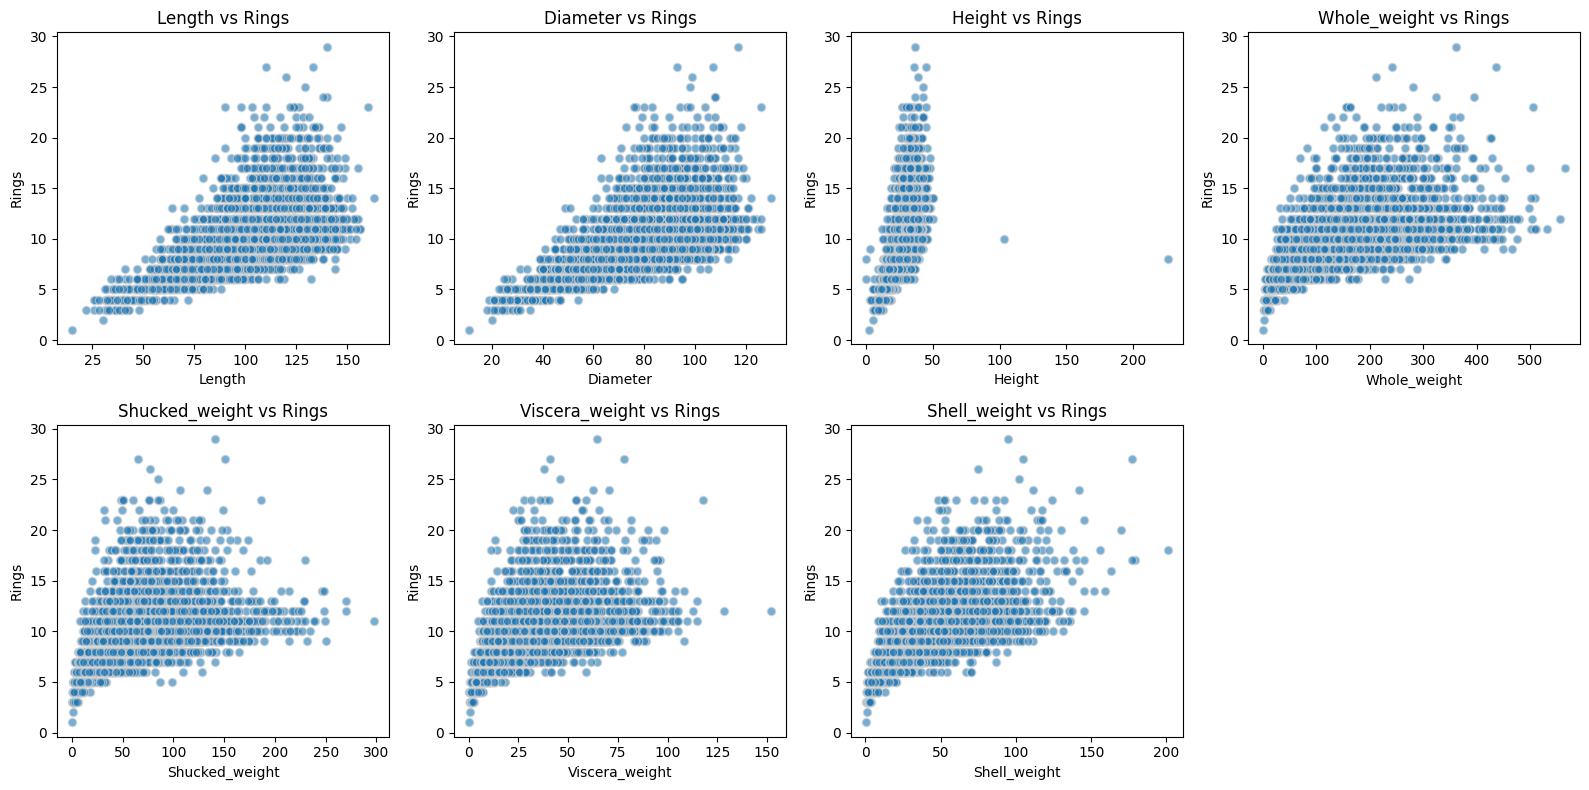

In [256]:
features= df.drop(columns=['Sex', 'Rings'], axis=0) #Nos quedamos solamente con los features continuos
target = df['Rings']

fig, axs = plt.subplots(2,4, figsize=(16, 8))
axs = axs.flatten()

for i, feature in enumerate(features.columns):
    axs[i].scatter(features[feature], target, alpha = 0.6, edgecolor= 'lightgray')
    axs[i].set_title(f'{feature} vs Rings')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Rings')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

Observamos que la variable `Height` tiene dos valores mucho mayores al rango de valores que toma en el 99% de los casos, lo que distorsiona la escala de los datos de `Height` en el *scatterplot* y también afectaría los modelos de regresión lineal que utilizaremos en los próximos pasos del trabajo, ya que estos modelos son sensibles a *outliers*. Por lo tanto se procedio a realizar un filtrado sobre esta caracteristica.

In [257]:
df = df[(df['Height'] < 70)]

sum(df.value_counts())

4175

Volvimos a realizar un *scatterplot* del *target* en función de las *features* para mostrar cómo cambió la escala de `Height` luego del filtrado; a su vez, la cantidad de filas pasó de 4177 a 4175.

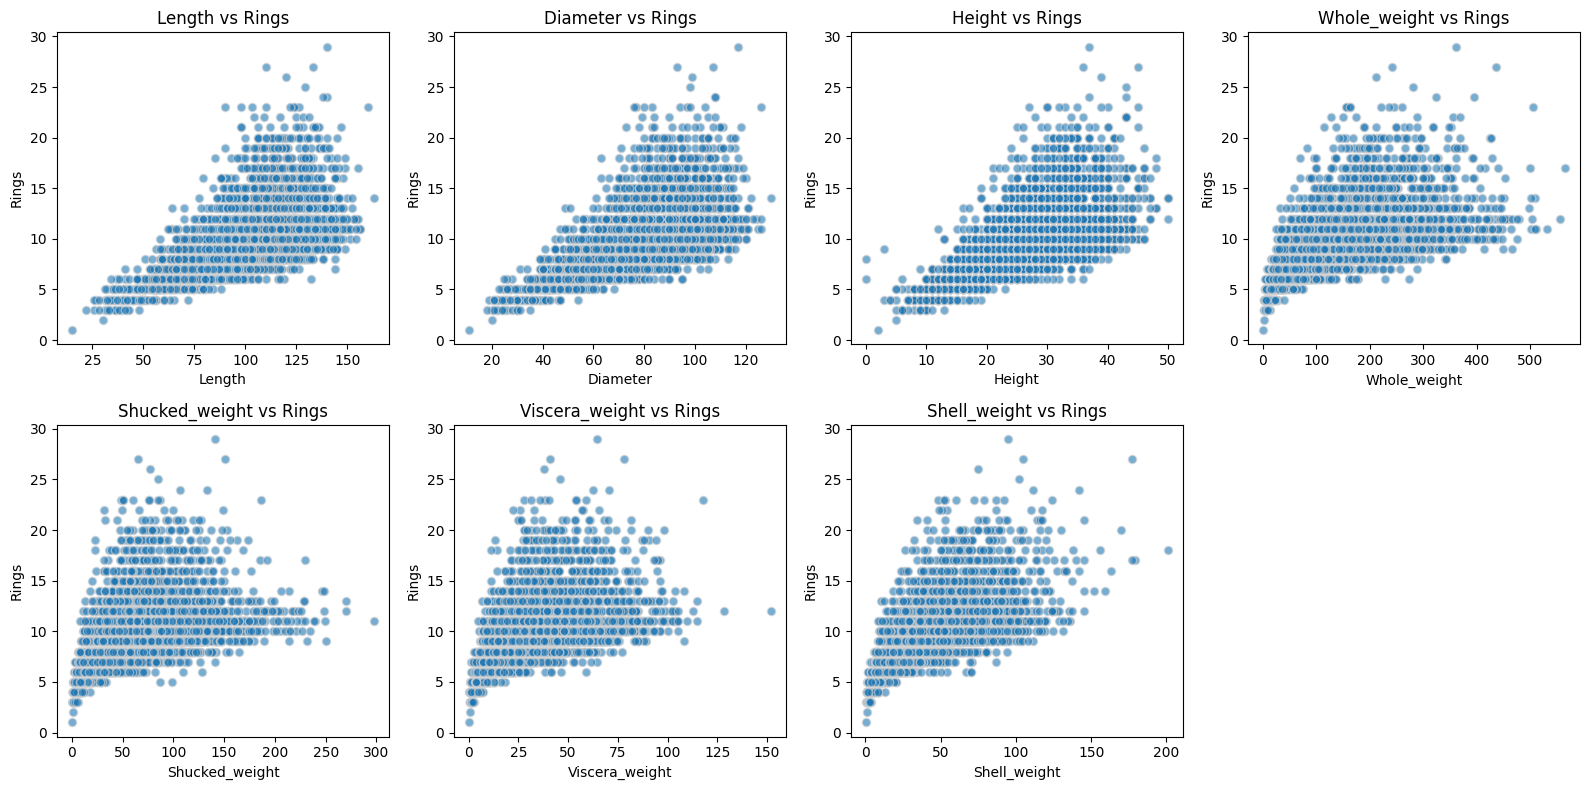

In [258]:
features= df.drop(columns=['Sex', 'Rings'], axis=0)
target = df['Rings']

fig, axs = plt.subplots(2,4, figsize=(16, 8))
axs = axs.flatten()

for i, feature in enumerate(features.columns):
    axs[i].scatter(features[feature], target, alpha = 0.6, edgecolor= 'lightgray')
    axs[i].set_title(f'{feature} vs Rings')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Rings')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()

## Primer modelo `Linear Regression (Benchmark)`

Como primer modelo, decidimos utilizar un modelo de regresión lineal `LinearRegression()`, utilizando solamente dos *features* del conjunto de datos: **`Length`** y **`Height`**. A su vez, este modelo será nuestro **benchmark** para comparar la performance con otros modelos.

Para medir la performance del modelo, utilizaremos las siguientes métricas de regresión:

- **R² (Coeficiente de Determinación)**: Esta métrica nos indica qué proporción de la variabilidad de la variable dependiente es explicada por las variables independientes en el modelo. Un valor más alto de R² sugiere que el modelo tiene un mejor ajuste a los datos.

- **RMSE (Root Mean Squared Error)**: El RMSE proporciona una medida del error en las predicciones del modelo, expresando la diferencia promedio entre los valores predichos y los valores reales. Un RMSE más bajo indica un mejor rendimiento del modelo.

Además, se utilizó **cross-validation** (validación cruzada) con 10 *folds* y con R² como métrica de performance, para evaluar la estabilidad y generalización del modelo. Esta técnica permite verificar cómo se desempeña el modelo en diferentes subconjuntos de los datos, asegurando que los resultados no sean simplemente un reflejo del conjunto de entrenamiento.

In [259]:
X = df[['Length', 'Height']]
y = df['Rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [260]:
def redondeo_primer_decimal(valor):
    valor = np.round(valor)
    return valor

Después de dividir los datos en conjuntos de entrenamiento y prueba, se entrenó el modelo utilizando el conjunto de entrenamiento. A continuación, se realizaron predicciones sobre ambos conjuntos, lo que permitió evaluar el desempeño del modelo mediante una comparación entre los resultados de entrenamiento y de prueba.

In [261]:
linear_reg = LinearRegression().fit(X_train, y_train)

# Predicciones para el entrenamiento y test
y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

redondeo_vectorizado = np.vectorize(redondeo_primer_decimal)

y_train_pred_round = redondeo_vectorizado(y_train_pred)
y_test_pred_round = redondeo_vectorizado(y_test_pred)

In [262]:
# Cálculo del RMSE y R2 para el conjunto de entrenamiento
rmse_train = root_mean_squared_error(y_train, y_train_pred_round)
r2_train = r2_score(y_train, y_train_pred_round)

# Cálculo del RMSE y R2 para el conjunto de testeo
rmse_test = root_mean_squared_error(y_test, y_test_pred_round)
r2_test = r2_score(y_test, y_test_pred_round)

# Cálculo del cross-validation score
score = cross_val_score(linear_reg, X_train, y_train, cv=10, scoring='r2')

# Cálculo del residuo
residue = y_test - y_test_pred_round

# Creación del DataFrame con las métricas de rendimiento
lr_perf_df = pd.DataFrame({
    'rmse_train': [rmse_train],
    'rmse_test': [rmse_test],
    'R2_train': [r2_train],
    'R2_test': [r2_test],
    'cv_score_mean': [score.mean()],
    'cv_score_std': [score.std()],
    'model': 'Linear_Reg'
})

lr_perf_df

,rmse_train,rmse_test,R2_train,R2_test,cv_score_mean,cv_score_std,model
0,2.606198,2.522524,0.355183,0.36738,0.363819,0.043736,Linear_Reg


### Resumen de Performance

- **`RMSE`**:
  - **Entrenamiento**: 2.606
  - **Prueba**: 2.523

- **`R²`**:
  - **Entrenamiento**: 0.355
  - **Prueba**: 0.368
  - Aproximadamente el 36% de la variabilidad de la variable dependiente parece ser explicada por el modelo.

- **`Cross-Validation-Score`**:
  - **Promedio**: 0.363
  - **Desviación Estándar**: 0.044
  - Rendimiento moderado del modelo con una variabilidad razonable en diferentes particiones del conjunto de datos.

#### Procedimos a graficar las predicciones en función de los valores reales del *target* y la distribución de los residuos.

Text(0, 0.5, 'Prediction')

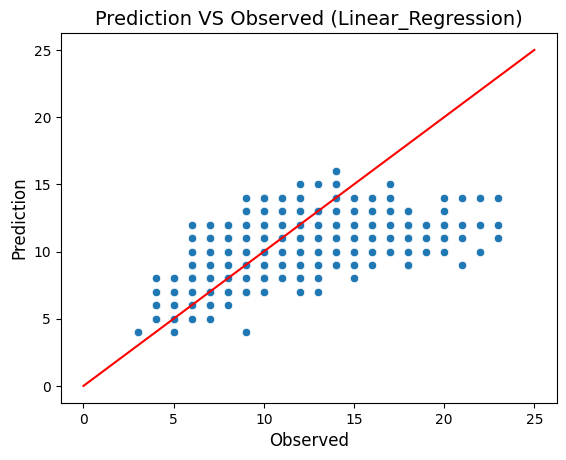

In [263]:
sns.scatterplot(x=y_test, y=y_test_pred_round) #Datos de testeo y la prediccion de los mismos

plt.plot([0,25],[0,25], color='red')
plt.title('Prediction VS Observed (Linear_Regression)', fontsize= 14)
plt.xlabel('Observed', fontsize= 12)
plt.ylabel('Prediction', fontsize= 12)


En el gráfico de dispersión, se observa la relación entre los valores observados y los valores predichos de un modelo de regresión lineal. La línea roja representa el caso ideal en el cual las predicciones coinciden perfectamente con los valores observados. Sin embargo, los puntos se dispersan alrededor de esta línea, lo que sugiere que el modelo tiene un un ajuste que no es perfecto. Ademas se observa que para los valores entre 0 a 14 el modelo tiende sobrestimar las predicciones. Y para valores mayores a 14 el modelo tiende a subestimar el predicciones. 

Text(0.5, 0, 'Residuals')

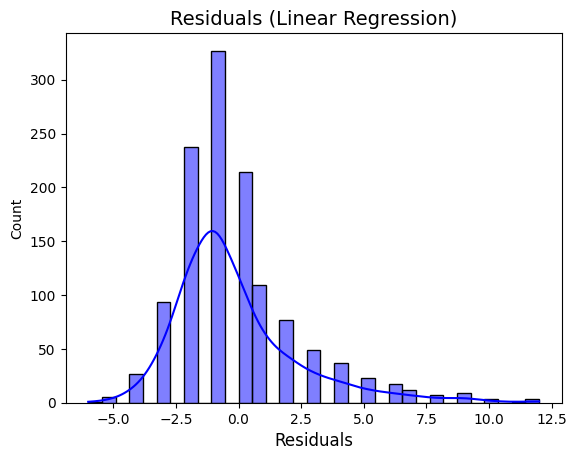

In [264]:
sns.histplot(x=residue, kde=True, color='blue')
plt.title('Residuals (Linear Regression)', fontsize= 14)
plt.xlabel('Residuals', fontsize= 12)

### Conclusiones del Modelo `Linear Regression (Benchmark)`

El modelo `LinearRegression()` con solo dos *features*, `Length` y `Height`, no parece captar muy bien los patrones en los datos, con un `R²` en test de 0.368. También tiene un rango de error que podría considerarse elevado, con un `RMSE` de 2.522 en test, lo que representa aproximadamente el 8.966% del rango total del *target*. Otra observación es que, al ser el *`RMSE_train` > `RMSE_test`* y el *`R²_train` < `R²_test`*, parecería estar indicando que hay un **underfitting** del modelo.

En línea con lo anteriormente mencionado, en este *scatterplot* *"Predictions VS Observed (Linear Regression)"* podemos ver que el modelo parece tener un sesgo al subestimar gran parte de las predicciones a medida que la cantidad de anillos aumenta, lo que podría indicar un underfitting.

Observación: las predicciones del modelo `Linear regresión (Benchmark)` devuelven valores continuos con coma, pero el *target* contra el que se comparan las predicciones tiene saltos discretos de 1 unidad, por lo que todas las predicciones fueron redondeadas según el criterio: *if (parte_decimal >= 5) → (valor_redondeado = parte_entera + 1), else (valor_redondeado = parte_entera)*.

## Segundo modelo: `Linear Regression (Lasso)`

Como segundo modelo, decidimos optar por `Linear_model.Lasso()` (Least Absolute Shrinkage and Selection Operator). Esta técnica no solo ayuda a simplificar el modelo a través de la regularización, sino que también selecciona las características más importantes, descartando aquellas que no aportan mucho. Como resultado, esperamos mejorar la capacidad predictiva del modelo y facilitar la interpretación de los resultados.

En este segundo modelo, se utilizan todas las características del abalon, tanto las del abalon vivo como las que requieren su sacrificio. Esto permitirá, al final, compararlo con un modelo que utiliza únicamente las características del abalon vivo.

Ademas, reescalamos las *features* que contienen valores continuos utilizando `StandardScaler` para poder analizar el peso de los coeficientes de cada atributo. A la única variable categórica, `'Sex'`, se le aplicó `OneHotEncoding`, ya que al ser categórica, si no la transformamos, no podríamos utilizarla en nuestro modelo de regresión.

In [265]:
X = df[['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight','Sex']]
y = df['Rings']  

columnas_continuas = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']
columnas_categoricas = ['Sex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


preprocesador = ColumnTransformer([
    ('scaler', StandardScaler(), columnas_continuas),
    ('onehot', OneHotEncoder(drop='first'), columnas_categoricas)
])

lasso_pipeline = Pipeline([
    ('preprocesador', preprocesador),
    ('lasso', linear_model.Lasso(alpha=0.02, max_iter=1000))
])

In [266]:
lasso_reg_optimo = lasso_pipeline.fit(X_train, y_train)

lrlasso_train_pred = lasso_reg_optimo.predict(X_train)
lrlasso_test_pred = lasso_reg_optimo.predict(X_test)

lrlasso_train_pred_red = redondeo_vectorizado(lrlasso_train_pred)
lrlasso_test_pred_red = redondeo_vectorizado(lrlasso_test_pred)

In [267]:
# Cálculo del RMSE y R² para el conjunto de entrenamiento
rmse_train = root_mean_squared_error(y_train, lrlasso_train_pred_red)
r2_train = r2_score(y_train, lrlasso_train_pred_red)

# Cálculo del RMSE y R² para el conjunto de prueba
rmse_test = root_mean_squared_error(y_test, lrlasso_test_pred_red)
r2_test = r2_score(y_test, lrlasso_test_pred_red)

# Cálculo del cross-validation score
score = cross_val_score(lasso_reg_optimo, X_train, y_train, cv=10, scoring='r2')


residue = y_test - lrlasso_test_pred_red

# Creación del DataFrame con las métricas de rendimiento
lrlasso_df = pd.DataFrame({
    'rmse_train': [rmse_train],
    'rmse_test': [rmse_test],
    'R2_train': [r2_train],
    'R2_test': [r2_test],
    'cv_score_mean': [score.mean()],
    'cv_score_std': [score.std()],
    'model': 'Linear_Reg_Lasso'
})

lrlasso_df

,rmse_train,rmse_test,R2_train,R2_test,cv_score_mean,cv_score_std,model
0,2.237063,2.147959,0.524908,0.541305,0.519072,0.052323,Linear_Reg_Lasso


### Performance `Linear Regression (Lasso)`.

- **RMSE**:
  - **Entrenamiento**: 2.237
  - **Prueba**: 2.148

- **R²**:
  - **Entrenamiento**: 0.525
  - **Prueba**: 0.541
  - Aproximadamente el 54% de la variabilidad de la variable dependiente es explicada por el modelo en los conjuntos de entrenamiento y prueba, respectivamente.

- **Cross-Validation-Score**:
  - **Promedio**: 0.519
  - **Desviación Estándar**: 0.052

Text(0, 0.5, 'Prediction')

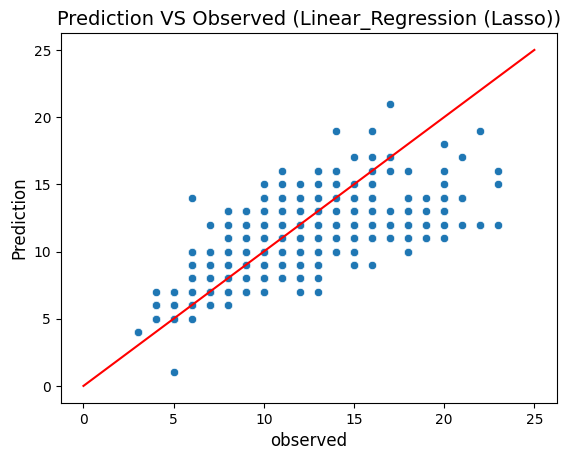

In [268]:
sns.scatterplot(x=y_test, y=lrlasso_test_pred_red)

plt.plot([0,25],[0,25], color='red')
plt.title('Prediction VS Observed (Linear_Regression (Lasso))', fontsize= 14)
plt.xlabel('observed', fontsize= 12)
plt.ylabel('Prediction', fontsize= 12)

En el gráfico de predicciones contra valores reales, se observa un mejor ajuste del modelo en comparación con el gráfico de referencia (benchmark). Además, a medida que aumentan las predicciones, se nota una menor dispersión de los datos, indicando un ajuste más preciso.

In [269]:
# Coeficientes del modelo Lasso
lasso_mod = lasso_reg_optimo.named_steps['lasso']
coeficients = lasso_mod.coef_

# Intercepto (ordenada al origen)
intercept = lasso_mod.intercept_

columnas_numericas = columnas_continuas
columnas_categoricas_transformadas = list(lasso_reg_optimo.named_steps['preprocesador'].named_transformers_['onehot'].get_feature_names_out(columnas_categoricas))
columnas_transformadas = columnas_numericas + columnas_categoricas_transformadas

# Creación del DataFrame con los atributos y sus pesos (coeficientes)
atributes_weight = pd.DataFrame({
    'Atribute': columnas_transformadas,
    'Weight': coeficients
})

# Selección de características con coeficientes distintos de cero (es decir, características seleccionadas por Lasso)
features_selected = atributes_weight[atributes_weight['Weight'] != 0]

# Ordenar las características por valor absoluto del coeficiente (peso)
features_selected = features_selected.reindex(features_selected.Weight.abs().sort_values(ascending=False).index).reset_index(drop=True)


print(f"Intercept: {intercept}")
print("")

print("Las características seleccionadas junto a sus coeficientes fueron:")
print(features_selected)


Intercept: 10.183251482999875

Las características seleccionadas junto a sus coeficientes fueron:
         Atribute    Weight
0  Shucked_weight -3.074136
1    Shell_weight  1.838408
2    Whole_weight  1.657315
3          Height  0.962853
4           Sex_I -0.622549
5        Diameter  0.583739
6  Viscera_weight -0.274899


- **Coeficientes ordenados por importancia de forma descendente**

  - **`Shucked_weight` (-3.074)**: Un aumento de 1 unidad en `Shucked_weight` reduce `Rings` en aproximadamente 3.074.

  - **`Shell_weight` (1.838)**: Un aumento de 1 unidad en `Shell_weight` incrementa `Rings` en aproximadamente 1.838.

  - **`Whole_weight` (1.657)**: Un aumento de 1 unidad en `Whole_weight` incrementa `Rings` en aproximadamente 1.657.

  - **`Height` (0.963)**: Un aumento de 1 unidad en `Height` incrementa `Rings` en aproximadamente 0.963.

  - **`Sex_I` (-0.623)**: Un aumento de 1 unidad en `Sex_I` reduce `Rings` en aproximadamente 0.623.

  - **`Diameter` (0.584)**: Un incremento de 1 unidad en `Diameter` incrementa `Rings` en aproximadamente 0.584.
  
  - **`Viscera_weight` (-0.275)**: Un aumento de 1 unidad en `Viscera_weight` reduce `Rings` en aproximadamente 0.275.

  - El **`intercept` (10.183)** representa el valor de `Rings` cuando todos los atributos son cero; es un valor razonable que está en el rango que puede tomar el *target*.

Text(0.5, 0, 'Residuals')

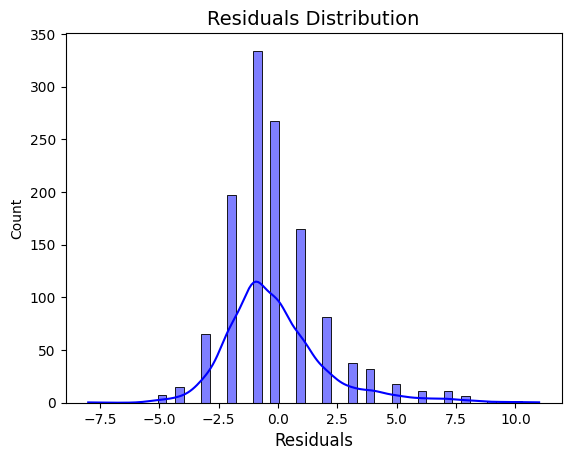

In [270]:
sns.histplot(x=residue, kde=True, color='blue')
plt.title('Residuals Distribution', fontsize= 14)
plt.xlabel('Residuals', fontsize= 12)

### Conclusiones del Modelo `Linear Regression (Lasso)`

Observando las métricas de performance, podríamos concluir que el modelo `Linear Regression (Lasso)` tiene una mejor performance que `LinearRegression (Benchmark)`.

- **R²**
  - `Linear Regression (Lasso)` obtuvo un `R²` en test de ***0.541***, lo que representa una mejora del ***47.01%*** respecto al `R²` de `LinearRegression (Benchmark)` (0.367).

- **RMSE**
  - `Linear Regression (Lasso)` obtuvo un `RMSE` en test de ***2.148***, lo que representa una reducción del ***14.91%*** respecto al `RMSE` de `LinearRegression (Benchmark)` (2.523).


El modelo **`Linear Regression`** se ha destacado en comparación con el modelo de regresión lineal con dos variables **`LinearRegression (Benchmark)`**, especialmente por su habilidad para detectar nuevos patrones en los datos, reducir el error y mitigar el riesgo de subajuste.

Una cosa que queremos destacar es el hecho de que tanto en `LinearRegression` como en `Linear Regression (Lasso)`, el `RMSE` y `R²` *dan peores resultados para el conjunto de entrenamiento en comparación con el conjunto de test*; no pudimos encontrar una explicación a este comportamiento.

Observación: las predicciones del modelo `Linear Regression (Lasso)` devuelven valores continuos con coma, pero el *target* contra el que se comparan las predicciones tiene saltos discretos de 1 unidad, por lo que todas las predicciones fueron redondeadas según el criterio: *if (parte_decimal >= 5) → (valor_redondeado = parte_entera + 1); else (valor_redondeado = parte_entera)*.Si parte_decimal≥5parte_decimal≥5, entonces valor_redondeado=parte_entera+1valor_redondeado=parte_entera+1; de lo contrario, valor_redondeado=parte_enteravalor_redondeado=parte_entera.

Para continuar con el trabajo se procedio a utilizar un modelo similar pero utilizando unicamente caracteristicas que mantengan al Abalon vivo.

## Tercer modelo: `Linear Regression (Lasso)` Sin sacrificio

Para el tercer modelo, se utilizó Linear_model.Lasso(), como en el caso anterior, pero esta vez considerando únicamente las características que preservan la vida del abalon. Estas variables incluyen 'Length', 'Diameter', 'Height' y 'Whole_weight'. Este enfoque permitirá comparar su desempeño con el modelo anterior que utiliza todas las características, incluidas las que requieren el sacrificio del animal.

In [271]:
X = df[['Length', 'Diameter', 'Height', 'Whole_weight']]
y = df['Rings']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lrlive_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', linear_model.Lasso(alpha=0.1, max_iter=1000)),
]).fit(X_train, y_train)

redondeo_vectorizado = np.vectorize(redondeo_primer_decimal)

In [272]:
lrlive_train_pred = lrlive_lasso.predict(X_train)
lrlive_test_pred = lrlive_lasso.predict(X_test)

lrlive_train_pred = redondeo_vectorizado(lrlive_train_pred)
lrlive_test_pred = redondeo_vectorizado(lrlive_test_pred)

rmse_train = root_mean_squared_error(y_train, lrlive_train_pred)
r2_train = r2_score(y_train, lrlive_train_pred)
rmse_test = root_mean_squared_error(y_test, lrlive_test_pred)
r2_test = r2_score(y_test, lrlive_test_pred)
score = cross_val_score(lrlive_lasso, X_train, y_train, cv=10, scoring='r2')

lrlive_lasso_df = pd.DataFrame({'rmse_train': [rmse_train], 'rmse_test': [rmse_test], 'R2_train': [r2_train],
                           'R2_test': [r2_test], 'cv_score_mean': [score.mean()], 'cv_score_std': [score.std()]})
print(lrlive_lasso_df)

   rmse_train  rmse_test  R2_train   R2_test  cv_score_mean  cv_score_std
0    2.604621   2.519675  0.355963  0.368808       0.364413      0.040446


### Coeficientes del modelo Lasso

In [273]:
# Coeficientes del modelo Lasso
lrlive_lasso_mod = lrlive_lasso.named_steps['lasso']
coeficients = lrlive_lasso_mod.coef_

# Intercepto (ordenada al origen)
intercept = lrlive_lasso_mod.intercept_

columnas_numericas = X.columns


# Creación del DataFrame con los atributos y sus pesos (coeficientes)
atributes_weight = pd.DataFrame({
    'Atribute': columnas_numericas,
    'Weight': coeficients
})

# Selección de características con coeficientes distintos de cero (es decir, características seleccionadas por Lasso)
features_selected = atributes_weight[atributes_weight['Weight'] != 0]

# Ordenar las características por valor absoluto del coeficiente (peso)
features_selected = features_selected.reindex(features_selected.Weight.abs().sort_values(ascending=False).index).reset_index(drop=True)


print(f"Intercept: {intercept}")
print("")

print("Las características seleccionadas junto a sus coeficientes fueron:")
print(features_selected)



Intercept: 9.984257357973991

Las características seleccionadas junto a sus coeficientes fueron:
   Atribute    Weight
0    Height  1.646701
1  Diameter  0.247545


Text(0, 0.5, 'Prediction')

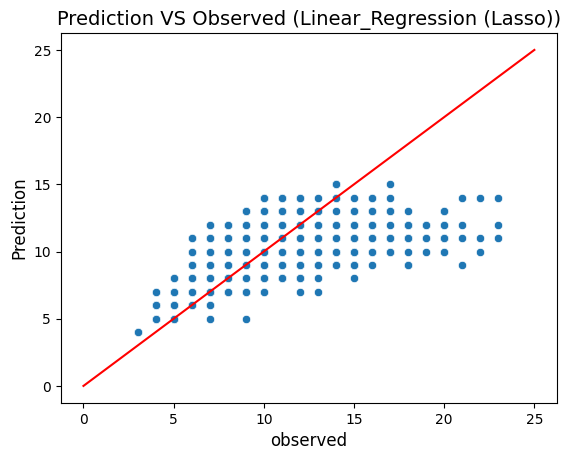

In [274]:
sns.scatterplot(x=y_test, y=lrlive_test_pred)

plt.plot([0,25],[0,25], color='red')
plt.title('Prediction VS Observed (Linear_Regression (Lasso))', fontsize= 14)
plt.xlabel('observed', fontsize= 12)
plt.ylabel('Prediction', fontsize= 12)

En este último gráfico de predicciones contra a valores reales, se observa una menor precisión del modelo para ajustar correctamente los datos. Además, la dispersión de los puntos aumenta a medida que los valores de predicción se incrementan, lo que indica un desvío más notable del modelo en los valores más altos.

## Conclusiones del modelo Lasso

Observando las métricas de rendimiento, podemos concluir que el modelo `Linear Regression (Lasso)` que utiliza todas las variables (incluidas las derivadas del sacrificio del abalón) presenta una mejor performance que el modelo `Lasso` que solo usa variables del abalón vivo.

- **R²**
  - El modelo `Linear Regression (Lasso)` que incluye todas las variables obtuvo un `R²` en test de ***0.541***, comparado con un `R²` de ***0.369*** en el modelo que usa solo variables vivas. Esto representa una mejora del ***46.61%*** en la capacidad explicativa del modelo cuando se utilizan todas las variables.

- **RMSE**
  - En cuanto al error, el `RMSE` en test del modelo con todas las variables fue de ***2.148***, mientras que el modelo con variables vivas obtuvo un `RMSE` de ***2.520***. Esto implica una reducción del error del ***17.31%*** al incluir todas las variables.

El modelo `Linear Regression (Lasso)` que utiliza todas las variables se destaca en comparación con el que solo considera las variables vivas. Aunque la mejora en R² sigue siendo limitada, estos resultados sugieren que un modelo que incluye todas las características logra una representación más precisa. Para obtener un desempeño más robusto, podría ser beneficioso explorar modelos más avanzados que optimicen aún más el ajuste y el poder predictivo.


## Conclusion

Al comparar los resultados del modelo Lasso utilizando solo las variables de abalón vivo frente a aquellos que incluyen todas las variables, se observa que el modelo con todas las variables presenta un mejor ajuste. En este caso, tanto el RMSE en los conjuntos de entrenamiento y prueba como el R² son más favorables, lo cual indica que el modelo logra una mejor precisión al utilizar las características adicionales derivadas del sacrificio del abalón.

Sin embargo, dado que los valores de R² son bajos en ambos casos, el modelo no logra una aproximación precisa. Esto significa que, con los modelos actuales, no es posible justificar de manera concluyente si es necesario incluir características que requieren sacrificar al animal. 

Tendremos que explorar modelos más avanzados podría mejorar el rendimiento y ofrecer una mejor base para tomar una decisión objetiva para poder predecir de manera correcta y eficiente la edad de los Abalones.

### Intergrantes del grupo 12
  - Ivan Lopez, mail: lopezivan1996@gmail.com
  - Bautista Turri, mail: turribautista551@gmail.com